# Migration

For modifying orbital elements, REBOUNDx offers two implementations.  `modify_orbits_direct` directly calculates orbital elements and modifies those, while `modify_orbits_forces` applies forces that when orbit-averaged yield the desired behavior.  We are currently working on a paper that considers when each one might be more appropriate.  We begin importing `rebound` and `reboundx` and setting up a simple simulation of two planets on initially eccentric and inclined orbits:

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
ainner = 50.
aouter = 1000.
e0 = 0.
inc0 = 0.

sim.add(m=1.)
sim.add(m=1,a=ainner,e=e0, inc=inc0)
sim.add(m=2.,a=aouter,e=e0, inc=inc0)
sim.move_to_com() # Moves to the center of momentum frame
#for p in sim.particles:
#    p.x += 5.

In [2]:
com1 = sim.calculate_com(last=2)
com2 = sim.calculate_com(last=3)
d = sim.particles[2].d

Now let's set up `reboundx` and here we choose to add `modify_orbits_forces`, which implements the migration using forces:

In [3]:
rebx = reboundx.Extras(sim)
params = rebx.add_modify_orbits_direct()

Both `modify_orbits_forces` and `modify_orbits_direct` exponentially alter the semimajor axis, on an e-folding timescale `tau_a`.  **If `tau_a` < 0, you get exponential damping, and for `tau_a` > 0, exponential growth, i.e.,**
\begin{equation}
a = a_0e^{t/\tau_a}
\end{equation}

In general, each body will have different damping timescales.  By default all particles have timescales of infinity, i.e., no effect.  The units of time are set by the units of time in your simulation.

Let's set a maximum time for our simulation, and give our two planets different (inward) migration timescales.  This can simply be done through:

In [4]:
tmax = 1.e3
sim.particles[1].tau_a = -tmax/2.  # this is for particles[1]
#sim.particles[2].tau_a = -tmax/2.     # this is for particles[2]

Now we run the simulation like we would normally with REBOUND.  Here we store the semimajor axes at 1000 equally spaced intervals:

In [5]:
Nout = 1000
a1,a2 = np.zeros(Nout), np.zeros(Nout)
es = np.zeros(Nout)
times = np.linspace(0.,tmax,Nout)
for i,time in enumerate(times):
    sim.integrate(time)
    a1[i] = sim.particles[1].a
    a2[i] = sim.particles[2].a
    es[i] = sim.particles[2].e

Now let's plot it on a linear-log scale to check whether we get the expected exponential behavior.  We'll also overplot the expected exponential decays for comparison.

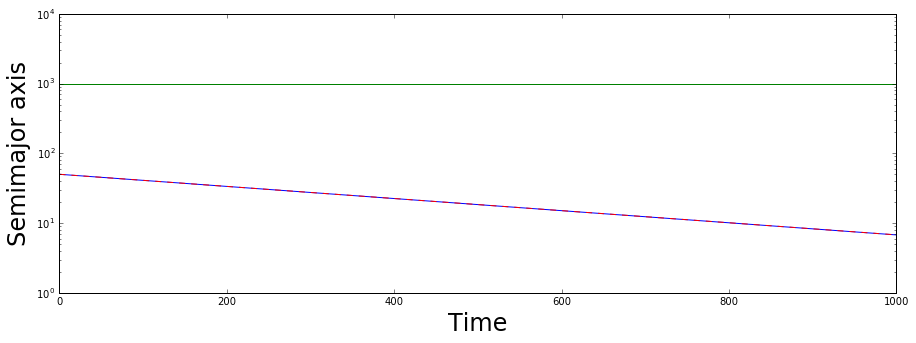

In [6]:
a1pred = [ainner*np.e**(t/sim.particles[1].tau_a) for t in times]
#a2pred = [aouter*np.e**(t/sim.particles[2].tau_a) for t in times]

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,a1)
plt.plot(times,a2)
plt.plot(times,a1pred, 'r--')
#plt.plot(times,a2pred, 'r--')
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("Semimajor axis", fontsize=24)

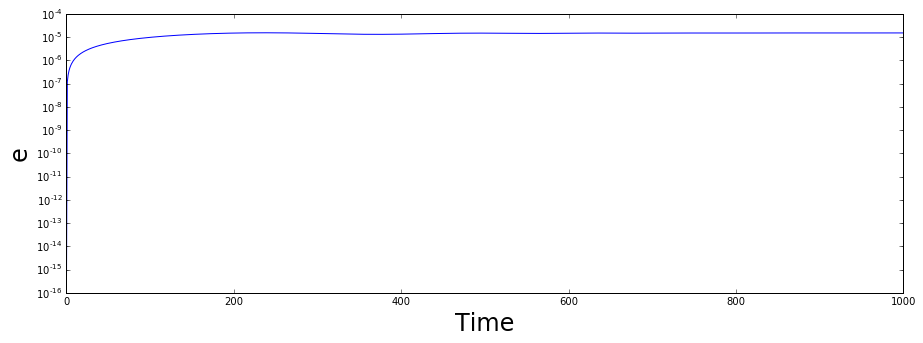

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
plt.plot(times,es)
plt.axes().set_xlabel("Time", fontsize=24)
plt.axes().set_ylabel("e", fontsize=24)

In [8]:
print(sim.calculate_com())

<rebound.Particle object, id=0 m=4.0 x=-4.547473508864641e-13 y=5.684341886080802e-14 z=0.0 vx=-6.114900252818245e-17 vy=1.3530843112619095e-16 vz=0.0>


In [9]:
print(sim.particles[2].d)

999.9993556377296


In [10]:
sim.particles[2].e

1.5039651082049597e-05

In [11]:
sim.status()

---------------------------------
REBOUND version:     	2.16.1
REBOUND built on:    	May 18 2016 08:36:39
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	1000.000000
Current timestep:    	0.446215
---------------------------------
<rebound.Particle object, id=0 m=1.0 x=-502.2000355885407 y=-32.69019587148436 z=0.0 vx=0.08954149631826941 vy=-0.2890245382912235 vz=0.0>
<rebound.Particle object, id=0 m=1.0 x=-495.79996896133 y=-30.513460623485702 z=0.0 vx=-0.08554340512361672 vy=0.22590514951165758 vz=0.0>
<rebound.Particle object, id=0 m=2.0 x=499.00000227493445 y=31.601828247485145 z=0.0 vx=-0.0019990455973264683 vy=0.031559694389783226 vz=0.0>
---------------------------------


In [12]:
print(com1)
print(sim.calculate_com(last=2))

<rebound.Particle object, id=0 m=2.0 x=-500.0 y=0.0 z=0.0 vx=0.0 vy=-0.031622776601683805 vz=0.0>
<rebound.Particle object, id=0 m=2.0 x=-499.00000227493535 y=-31.60182824748503 z=0.0 vx=0.001999045597326346 vy=-0.031559694389782955 vz=0.0>


In [13]:
print(com2)
print(sim.calculate_com(last=3))

<rebound.Particle object, id=0 m=4.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=-1.3877787807814457e-17 vz=0.0>
<rebound.Particle object, id=0 m=4.0 x=-4.547473508864641e-13 y=5.684341886080802e-14 z=0.0 vx=-6.114900252818245e-17 vy=1.3530843112619095e-16 vz=0.0>


In [14]:
print(d)
print(sim.particles[2].d)

1000.0
999.9993556377296


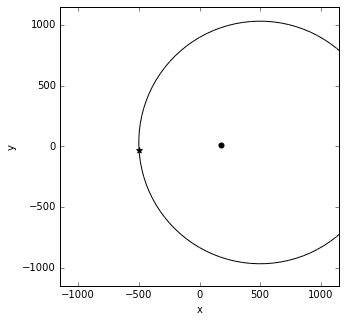

In [15]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

**Coordinate Systems**

Everything in REBOUND by default uses jacobi coordinates.  If you would like to change the reference relative to which the particles are damped, we alter the field in the parameters object returned when we added the effect (we called this `params` above):

In [16]:
params.coordinates = reboundx.coordinates["HELIOCENTRIC"]

for everything to be referenced to `sim.particles[0]`, or

In [17]:
params.coordinates = reboundx.coordinates["BARYCENTRIC"]

to use the barycenter of the whole system.